In [25]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"   # Enable to train but not to use intermediate layers
import mido
import pandas as pd
import numpy as np

In [26]:
# To read data
# PreSet = mido.read_syx_file('2.syx')
# d = PreSet[0].data
# t = PreSet[0].time
# # We change one value 
# d = np.array(d)
#d[3]=32 #from 32 to 31

#### The new part --------------------------------------
with open('compact.bin', 'rb') as f:
    compact = bytearray(f.read()) # open the largest existing dataset of unique DX7 voices (from https://github.com/bwhitman/learnfm)
    
presets = np.array(compact)
presets = presets.reshape((-1,128)) # each voice is encoded in 128 bytes
print("The dataset contains "+str(presets.shape[0])+" voices")

def preprocess_dataset(data):
    maxs = data.max(axis=0)
    assert maxs.shape == (128,)
    data = data/maxs # normalize
    
    return data

d = preprocess_dataset(presets)



The dataset contains 31380 voices


In [3]:
# To write data 
# time = t
# data = d
# wr = mido.Message('sysex', data=data, time=0)
# mido.write_syx_file('patch.syx', [wr])
# mido.read_syx_file('patch.syx');

In [4]:
Conf = []
import os
for file in os.listdir():  # We just take all files with the right format
    if file.endswith( ".syx" ) or file.endswith( ".SYX" ):
        if len(mido.read_syx_file(file))>0:
            Conf.append(np.array(mido.read_syx_file(file)[0].data))


In [5]:
elements = [Conf[i] for i in range(len(Conf))]
#Sdata = np.concatenate(elements).reshape(len(elements),-1)
Sdata = d

In [6]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline


In [7]:
reducer = umap.UMAP()

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(Sdata)

In [9]:
embedding = reducer.fit_transform(Sdata)

c:\users\v_301\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python36\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
c:\users\v_301\appdata\local\programs\python\python36\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File 

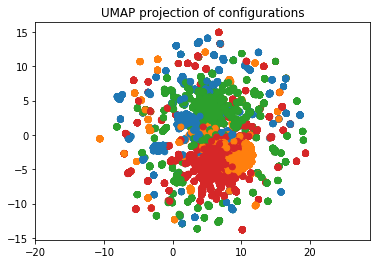

In [14]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in kmeans.labels_])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of configurations');
#There are no clear clusters

In [11]:
# Auto encoder 

In [15]:
import keras
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [16]:
scaler = StandardScaler()

S=Sdata
scaler.fit_transform(S)


array([[ 0.44137917, -0.61885588, -0.63832171, ...,  1.70134068,
        -1.04588249, -0.86166212],
       [-1.95106504, -0.72592244, -0.25271249, ..., -0.64973105,
        -0.57380276, -0.21205277],
       [-0.05360929,  0.05923235,  0.58277415, ...,  0.57547534,
        -1.04588249, -0.86166212],
       ...,
       [ 0.1526359 ,  0.55887631,  0.16503083, ...,  1.13840801,
         1.61799602,  2.11889842],
       [-0.25985448,  0.84438714, -0.95966272, ..., -0.81529948,
        -0.47264281, -0.05920352],
       [-1.53857466,  0.13061006, -0.63832171, ..., -0.58350367,
        -0.57380276, -0.09741583]])

In [17]:
model = Sequential()
model.add(Dense(512,activation='relu',input_dim=128))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))

model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))

model.compile(loss=keras.losses.mean_squared_error,
             optimizer='adam',
             metrics = ['mean_absolute_percentage_error'])
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_____

In [23]:
model.fit(S,S,verbose=1,epochs=100,batch_size=512)

Epoch 1/100
31380/31380 [==============================] - 14s 452us/step - loss: 0.0669 - mean_absolute_percentage_error: 24310678.8871
Epoch 2/100
31380/31380 [==============================] - 2s 63us/step - loss: 0.0190 - mean_absolute_percentage_error: 10297248.5122
Epoch 3/100
31380/31380 [==============================] - 5s 154us/step - loss: 0.0167 - mean_absolute_percentage_error: 10386433.9026
Epoch 4/100
31380/31380 [==============================] - 6s 179us/step - loss: 0.0144 - mean_absolute_percentage_error: 10259948.0537
Epoch 5/100
31380/31380 [==============================] - 3s 103us/step - loss: 0.0135 - mean_absolute_percentage_error: 9885600.8654
Epoch 6/100
31380/31380 [==============================] - 3s 105us/step - loss: 0.0130 - mean_absolute_percentage_error: 9674747.6742
Epoch 7/100
31380/31380 [==============================] - 3s 101us/step - loss: 0.0123 - mean_absolute_percentage_error: 9196441.2022
Epoch 8/100
31380/31380 [==========================

Epoch 60/100
31380/31380 [==============================] - 3s 104us/step - loss: 0.0066 - mean_absolute_percentage_error: 5332337.9776
Epoch 61/100
31380/31380 [==============================] - 3s 106us/step - loss: 0.0064 - mean_absolute_percentage_error: 5128520.6185
Epoch 62/100
31380/31380 [==============================] - 3s 106us/step - loss: 0.0061 - mean_absolute_percentage_error: 4936183.6658
Epoch 63/100
31380/31380 [==============================] - 3s 102us/step - loss: 0.0060 - mean_absolute_percentage_error: 4783150.3390
Epoch 64/100
31380/31380 [==============================] - 3s 103us/step - loss: 0.0059 - mean_absolute_percentage_error: 4748333.0872
Epoch 65/100
31380/31380 [==============================] - 3s 106us/step - loss: 0.0066 - mean_absolute_percentage_error: 5017801.9050
Epoch 66/100
31380/31380 [==============================] - 3s 106us/step - loss: 0.0063 - mean_absolute_percentage_error: 4764758.3628
Epoch 67/100
31380/31380 [======================

In [27]:
model.load_weights('model.h5')
## Values to latent representation

In [28]:
from keras.models import Model
#From complete representation to latent values of S 
layer_name = 'dense_5' #Intermediate 
final_name = 'dense_9'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(S)

In [29]:
latent_rep = intermediate_layer_model.predict(S[0].reshape(1,128))
latent_rep

array([[5.8273935, 6.827771 , 5.5943685, 7.0004277, 7.2746944, 7.6504874,
        8.180881 , 8.10254  , 6.820442 , 6.873222 ]], dtype=float32)

## Latent representation to complete values

In [30]:
from keras import backend as K
# with a Sequential model
get_middle_layer_output = K.function([model.layers[9].input],
                                  [model.layers[-1].output])
layer_output = get_middle_layer_output([latent_rep])[0]
layer_output

array([[0.68484116, 0.23753902, 0.16218245, 0.25423384, 0.73913175,
        0.6288851 , 0.        , 0.        , 0.13753043, 0.09078663,
        0.06429772, 0.        , 0.34578964, 0.04733365, 0.5382758 ,
        0.06766444, 0.29060015, 0.4068113 , 0.17617343, 0.13996428,
        0.25532925, 0.42755568, 0.3297174 , 0.        , 0.        ,
        0.14877565, 0.        , 0.09102942, 0.        , 0.2791475 ,
        0.        , 0.5694248 , 0.10687482, 0.        , 0.34366345,
        0.21373157, 0.11719966, 0.2802805 , 0.7548833 , 0.43643683,
        0.01737354, 0.        , 0.12367043, 0.        , 0.10352437,
        0.        , 0.31679332, 0.        , 0.6664943 , 0.        ,
        0.00609839, 0.61997616, 0.23841941, 0.21259525, 0.25575644,
        0.43877494, 0.69200176, 0.02328823, 0.        , 0.09379537,
        0.        , 0.07947905, 0.        , 0.41733265, 0.        ,
        0.36819902, 0.        , 0.        , 0.3994904 , 0.30664134,
        0.16582608, 0.22809413, 0.76291054, 0.63

# One example 

In [31]:
# We can compare the reconstruction
pd.DataFrame(scaler.inverse_transform(layer_output).T,S[0]).T

,0.708661,0.177665,0.088496,0.325301,0.755725,0.629921,0.000000,0.000000,0.149020,0.000000,...,0.603659,0.754967,0.487923,0.737226,0.538462,0.519608,0.580838,0.570093,0.201258,0.166667
0,0.755136,0.299473,0.198723,0.324228,0.805639,0.7509,0.351504,0.063092,0.112816,0.043544,...,0.489047,0.667434,0.468389,0.738089,0.440154,0.436828,0.55333,0.387469,0.491817,0.330571


In [37]:
# Writing the result into a file 
# integerData=[(pd.Series(scaler.inverse_transform(layer_output)[0])).values[i] 
#              for i in range(len(layer_output[0]))]
# integerData = pd.Series(integerData)
# # Cliping for un learned values that the autoencoder creates. 
# integerData = integerData.clip(0, 128, axis=0)
# data = np.array(integerData)
# wr = mido.Message('sysex', data=data, time=0)
# mido.write_syx_file('patch.syx', [wr])
# mido.read_syx_file('patch.syx')

In [39]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Sdata)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

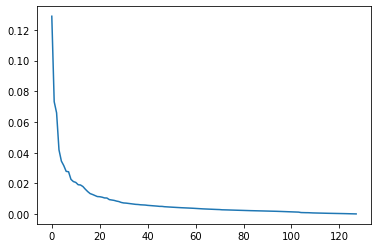

In [43]:
plt.plot(pca.explained_variance_ratio_)
# Some features are more give more variance to the configuration 

In [48]:
DimensonsFor95Percent = pd.Series (pca.explained_variance_ratio_.cumsum())
sum(DimensonsFor95Percent>.95)
#This means that by linear methods we would need to take 46 dimensions to preserve 95% of variance

46